# Cahart Four Factor Model #

### Using Beta as a Factor ###

In [116]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Statistics
import statsmodels.api as sm

# Manipulate Files
import os

# Pretty Notation
from IPython.display import display, Math

In [117]:
# Get the important data for the Risk Free Rate

rfr = pd.read_csv(r"..\additional_data\rfr.csv")
rfr = rfr.set_index('Date')
rfr.index = pd.to_datetime(rfr.index, dayfirst=True)

# Get the important data for the S&P500

sp500 = pd.read_csv(r"..\additional_data\sp500.csv")
sp500 = sp500.set_index('Date')
sp500.index = pd.to_datetime(sp500.index)

# Get the data for the Stocks' Betas

betas_df = pd.read_csv(r"..\additional_data\betas.csv")
betas_df = betas_df.set_index('Date')
betas_df.index = pd.to_datetime(betas_df.index)

In [118]:
# Folder Path
folder_path = r"..\stocks"

# Dictionary to store the DataFrames
dataframes = {}

# List all files in the folder
for file in os.listdir(folder_path):
    if file.endswith(".csv"):
        # Full path to the file
        file_path = os.path.join(folder_path, file)
        
        # Read the Excel file
        df = pd.read_csv(file_path)
        df = df.set_index("Date")
        df.index = pd.to_datetime(df.index)

        df = df[['Adjusted_close', 'Market_cap_calculado']]

        df = df.rename(columns={
            'Adjusted_close':'adj_close',
            'Market_cap_calculado':'market_cap',
        })

        # Fill nans
        df['adj_close'] = df['adj_close'].interpolate(method='linear')
        df['market_cap'] = df['market_cap'].interpolate(method='linear')

        df = df.loc['2015-01-01':]

        df.dropna(inplace=True)
        
        if len(df) >= 2000:
            # File name without extension
            file_name = os.path.splitext(file)[0]
            
            # Guardar en el diccionario
            dataframes[file_name] = df
            print(f"File loaded: {file_name} ({len(df)} rows)")
        else:
            print(f"File skipped (less than 2000 rows after cleaning): {file}")

print(f"\nTotal files loaded: {len(dataframes)}")
print("Files loaded:", list(dataframes.keys()))

File loaded: A (2472 rows)
File loaded: AAPL (2472 rows)
File loaded: ABBV (2472 rows)
File skipped (less than 2000 rows after cleaning): ABNB.csv
File loaded: ABT (2472 rows)
File loaded: ADBE (2472 rows)
File loaded: ADI (2472 rows)
File loaded: ADM (2472 rows)
File loaded: ADP (2472 rows)
File loaded: ADSK (2472 rows)
File loaded: AEE (2472 rows)
File loaded: AEP (2472 rows)
File loaded: AES (2472 rows)
File loaded: AFL (2472 rows)
File loaded: AIG (2472 rows)
File loaded: AIZ (2472 rows)
File loaded: AJG (2472 rows)
File loaded: AKAM (2472 rows)
File loaded: ALB (2472 rows)
File loaded: ALGN (2472 rows)
File loaded: ALL (2472 rows)
File loaded: AMAT (2472 rows)
File loaded: AMD (2472 rows)
File loaded: AME (2472 rows)
File loaded: AMGN (2472 rows)
File loaded: AMP (2472 rows)
File loaded: AMT (2472 rows)
File loaded: AMZN (2472 rows)
File loaded: ANET (2472 rows)
File loaded: ANSS (2472 rows)
File loaded: AOS (2472 rows)
File loaded: APA (2472 rows)
File loaded: APD (2472 rows)
Fil

In [119]:
# Create a whole new dataframe that contains all the stocks betas

rets_series = []

for stock, df in dataframes.items():
    series = df['adj_close'].pct_change(1).rename(stock)  
    series = series.iloc[1:]
    rets_series.append(series)

# Concat
returns_df = pd.concat(rets_series, axis=1)
returns_df = returns_df.apply(lambda x: x.fillna(x.mean()), axis=0)

returns_df.dropna(inplace = True)

returns_df

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,-0.018738,-0.028172,-0.018819,0.000223,-0.004976,-0.018275,-0.034602,-0.000720,-0.014614,-0.010002,...,-0.013804,0.000000,-0.017020,-0.011351,-0.027362,-0.062237,-0.020318,0.037303,-0.014077,-0.006003
2015-01-06,-0.015578,0.000094,-0.004950,-0.011356,-0.020144,-0.023384,-0.019713,-0.008350,-0.019775,-0.011641,...,-0.017107,-0.001108,-0.021331,0.005321,-0.005316,-0.005881,-0.012274,-0.008477,-0.007205,-0.009756
2015-01-07,0.013272,0.014022,0.040417,0.008108,0.008223,0.010516,0.015031,0.008784,-0.002087,0.007778,...,0.016218,0.003050,0.029368,0.008635,0.010133,0.007887,0.033138,0.024870,0.025465,0.020643
2015-01-08,0.029975,0.038422,0.010459,0.020554,0.025383,0.017655,-0.014609,0.022940,0.024747,0.003528,...,0.019657,0.010779,0.012031,0.011599,0.016645,0.007546,0.017420,0.010617,0.021359,0.015399
2015-01-09,-0.007337,0.001072,-0.027355,-0.010508,-0.014743,-0.000730,-0.008530,-0.007162,-0.009014,-0.011206,...,-0.011453,-0.001367,0.012499,-0.012285,-0.001410,-0.018863,-0.001767,-0.014424,0.014613,0.001584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,-0.024130,-0.002622,0.011901,-0.007437,-0.009242,-0.004653,-0.007839,0.001478,-0.004486,-0.005327,...,-0.002959,-0.019820,0.010471,0.003941,0.005163,-0.008678,-0.004776,-0.008935,-0.001584,0.000317
2024-10-23,-0.003222,-0.021623,-0.004662,0.007664,-0.016386,0.009928,0.007003,-0.004462,-0.007574,0.016408,...,0.000140,0.006319,-0.017304,0.010050,-0.003563,0.002664,0.004949,0.004220,-0.010511,-0.002744
2024-10-24,-0.017590,-0.000823,0.009421,-0.004017,-0.004453,0.012475,0.007489,-0.002103,-0.001834,-0.002130,...,0.154343,0.008791,0.002252,0.012282,-0.005654,-0.008123,-0.006417,-0.006686,-0.016409,-0.039632


In [120]:
# Create a whole new dataframe that contains all the stocks betas

mktcap_series = []

for stock, df in dataframes.items():
    series = df['market_cap'].rename(stock)  
    series = series.iloc[1:]
    mktcap_series.append(series)

# Concat
mktcap_df = pd.concat(mktcap_series, axis=1)
mktcap_df = mktcap_df.apply(lambda x: x.fillna(x.mean()), axis=0)

# Drop nans
mktcap_df.dropna(inplace = True)

# Apply Logs and EMA (maybe)
mktcap_df = np.log(mktcap_df)
mktcap_df

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,23.310518,27.158261,25.354579,24.963717,24.303701,23.554108,24.216559,24.414648,23.314509,23.125296,...,22.020014,23.586216,23.406606,23.616339,26.669565,22.608591,23.826613,23.684291,22.100188,23.794869
2015-01-06,23.294818,27.158355,25.349617,24.952296,24.283351,23.530446,24.196649,24.406262,23.294536,23.113587,...,22.002759,23.585107,23.385044,23.621646,26.664234,22.602693,23.814263,23.675778,22.092957,23.785065
2015-01-07,23.308003,27.172280,25.389238,24.960372,24.291541,23.540908,24.211569,24.415008,23.292447,23.121335,...,22.018847,23.588152,23.413990,23.630244,26.674316,22.610549,23.846864,23.700344,22.118103,23.805498
2015-01-08,23.337537,27.209982,25.399643,24.980717,24.316607,23.558408,24.196852,24.437689,23.316893,23.124857,...,22.038314,23.598874,23.425949,23.641776,26.690823,22.618067,23.864134,23.710905,22.139237,23.820779
2015-01-09,23.330173,27.211054,25.371907,24.970154,24.301754,23.557678,24.188286,24.430501,23.307838,23.113587,...,22.026795,23.597506,23.438370,23.629415,26.689413,22.599024,23.862366,23.696376,22.153745,23.822363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,24.416692,28.909263,26.532427,26.031113,26.123266,25.437491,24.075587,25.501514,24.850774,23.876616,...,23.757865,23.859889,23.127566,24.292551,27.007904,24.186178,24.346917,23.784920,23.677344,25.177636
2024-10-23,24.416692,28.887403,26.527754,26.031113,26.106744,25.447370,24.082566,25.497042,24.843171,23.892891,...,23.758005,23.866188,23.110111,24.302551,27.004335,24.188839,24.351854,23.789132,23.666778,25.174888
2024-10-24,24.416692,28.886579,26.537131,26.031113,26.102281,25.459768,24.090027,25.494936,24.841336,23.890759,...,23.900158,23.873894,23.112361,24.314759,26.998665,24.180682,24.345417,23.782424,23.650233,25.134450


In [121]:
# See the betas
betas_df = betas_df[returns_df.columns]

betas_df

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-08,1.169801,1.147189,1.020613,1.204812,0.999815,1.243746,0.981288,1.049395,1.009929,0.559332,...,0.856893,0.937214,1.708455,0.531819,1.064428,1.007787,1.002596,0.821984,1.494902,1.020760
2016-01-11,1.167770,1.135761,1.032587,1.210169,1.001209,1.238406,0.974001,1.047316,1.012501,0.559818,...,0.856111,0.937283,1.721904,0.537210,1.071017,1.007377,1.003930,0.818455,1.485398,1.023555
2016-01-12,1.166375,1.136806,1.024002,1.211396,1.003453,1.241084,0.972430,1.048343,1.015570,0.559591,...,0.854448,0.937870,1.718190,0.537422,1.070249,1.007402,0.999302,0.813795,1.482889,1.019380
2016-01-13,1.162057,1.134450,1.032051,1.216526,0.999187,1.242375,0.980352,1.049293,1.004531,0.557271,...,0.857982,0.923881,1.705672,0.532184,1.077893,1.009344,1.007880,0.828707,1.487805,1.020597
2016-01-14,1.172151,1.130829,1.095173,1.213185,0.987322,1.241761,0.976254,1.050547,1.079909,0.543485,...,0.830912,0.902395,1.727706,0.520218,1.025449,1.009536,0.980446,0.820496,1.519260,1.043191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,0.876024,1.037784,0.194116,0.161045,1.152206,1.811336,0.440483,0.369979,1.321823,0.050615,...,0.659139,0.629752,0.945839,0.030220,0.178951,1.048215,0.402963,0.558583,1.298215,0.644560
2024-10-23,0.885034,1.040036,0.185126,0.162425,1.155704,1.812294,0.440543,0.368008,1.320912,0.048642,...,0.657083,0.631516,0.950898,0.028141,0.178514,1.057987,0.403819,0.558005,1.297213,0.643499
2024-10-24,0.882041,1.054079,0.192155,0.158307,1.156394,1.783464,0.423049,0.364567,1.315633,0.022642,...,0.645426,0.618673,0.963019,0.010037,0.175143,1.046621,0.393233,0.547803,1.299909,0.640561


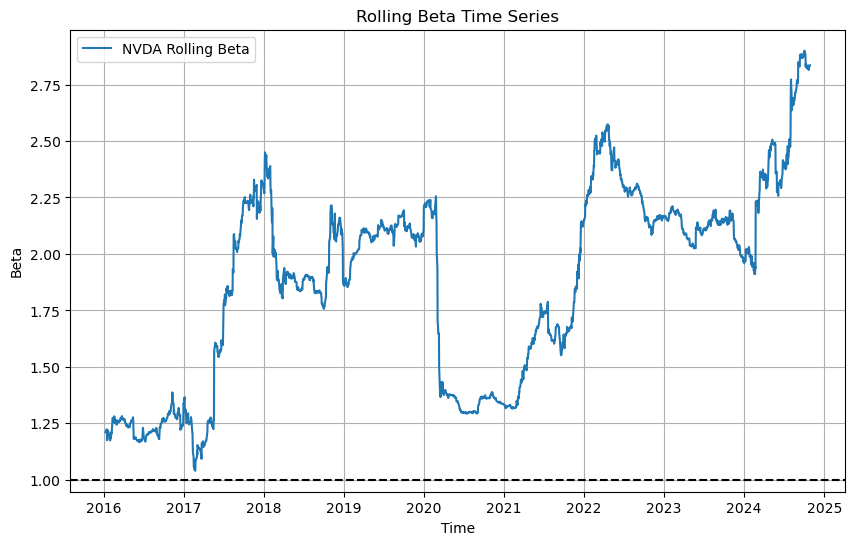

In [122]:
# Create Plot

ticker = 'NVDA'

plt.figure(figsize=(10, 6))
plt.plot(betas_df[ticker], label=f'{ticker} Rolling Beta', alpha=1)
plt.axhline(y=1, color='black', linestyle='dashed')

# Config
plt.title('Rolling Beta Time Series')
plt.xlabel('Time')
plt.ylabel('Beta')
plt.legend()
plt.grid()

# Show
plt.show()

In [123]:
# Define the Decomposition Function
def betas_decomposition(
    target_df, 
    mktcap_df, 
    betas_df
):
    # Common Indexes
    common_index = target_df.index.intersection(betas_df.index).intersection(mktcap_df.index)
    
    # Reindex
    target_df = target_df.loc[common_index]
    mktcap_df = mktcap_df.loc[common_index]
    betas_df = betas_df.loc[common_index]

    # Initialize lists to store portfolio returns
    aggressive_list, neutral_list, defensive_list = [], [], []
    
    # Get unique quarters
    months = sorted(set([date.to_period('M') for date in common_index]))
    
    # Dictionary to store quarterly classifications and weights
    monthly_classifications = {}

    for month in months:
        # Select only the last available date of the quarter
        month_dates = [date for date in common_index if date.to_period('M') == month]
        rebalance_date = month_dates[-1]  # Last day of the quarter
        
        # Value factor (P/B ratio) for rebalance date
        betas_factor_df = pd.DataFrame([betas_df.loc[rebalance_date]], index=['beta']).T.dropna()
        
        # Classify stocks into Low, Neutral, and High based on quantiles
        lower = betas_factor_df['beta'].quantile(0.3)
        upper = betas_factor_df['beta'].quantile(0.7)

        betas_factor_df['beta_class'] = 'neutral'
        betas_factor_df.loc[betas_factor_df['beta'] <= lower, 'beta_class'] = 'defensive'
        betas_factor_df.loc[betas_factor_df['beta'] >= upper, 'beta_class'] = 'aggressive'
        
        # Market cap data
        market_caps_df = pd.DataFrame([mktcap_df.loc[rebalance_date]], index=['mkt_cap']).T
        
        # Assign market caps to value classes
        defensive_mktcap_df = market_caps_df.loc[betas_factor_df[betas_factor_df['beta_class'] == 'defensive'].index]
        neutral_mktcap_df = market_caps_df.loc[betas_factor_df[betas_factor_df['beta_class'] == 'neutral'].index]
        aggressive_mktcap_df = market_caps_df.loc[betas_factor_df[betas_factor_df['beta_class'] == 'aggressive'].index]
        
        # Compute weights
        defensive_weights = defensive_mktcap_df['mkt_cap'] / defensive_mktcap_df['mkt_cap'].sum()
        neutral_weights = neutral_mktcap_df['mkt_cap'] / neutral_mktcap_df['mkt_cap'].sum()
        aggressive_weights = aggressive_mktcap_df['mkt_cap'] / aggressive_mktcap_df['mkt_cap'].sum()
        
        # Store classifications and weights
        monthly_classifications[month] = {
            "defensive": defensive_weights,
            "neutral": neutral_weights,
            "aggressive": aggressive_weights
        }
    
    # Iterate over all available dates to compute daily returns
    for date in common_index:
        month_key = date.to_period('M')  # Get quarter of the current date
        
        if month_key in monthly_classifications:
            # Retrieve stored classification and weights
            defensive_weights = monthly_classifications[month_key]["defensive"]
            neutral_weights = monthly_classifications[month_key]["neutral"]
            aggressive_weights = monthly_classifications[month_key]["aggressive"]
            
            # Retrieve daily returns
            target = pd.DataFrame([target_df.loc[date]], index=['returns']).T
            
            defensive_returns = target.reindex(defensive_weights.index).dropna()
            neutral_returns = target.reindex(neutral_weights.index).dropna()
            aggressive_returns = target.reindex(aggressive_weights.index).dropna()
            
            # Compute portfolio returns
            defensive_result = defensive_weights.reindex(defensive_returns.index).T @ defensive_returns
            neutral_result = neutral_weights.reindex(neutral_returns.index).T @ neutral_returns
            aggressive_result = aggressive_weights.reindex(aggressive_returns.index).T @ aggressive_returns
            
            # Store results
            defensive_list.append(defensive_result.values[0] if not defensive_result.empty else None)
            neutral_list.append(neutral_result.values[0] if not neutral_result.empty else None)
            aggressive_list.append(aggressive_result.values[0] if not aggressive_result.empty else None)

    # Create final DataFrame
    betas_portfolios = pd.DataFrame({
        'aggressive': aggressive_list,
        'neutral': neutral_list,
        'defensive': defensive_list
    }, index=common_index)
    
    return betas_portfolios

In [124]:
# Create DataFrames

betas_portfolios_returns = betas_decomposition(returns_df, mktcap_df, betas_df)

betas_portfolios_returns

,aggressive,neutral,defensive
Date,,,
2016-01-08,-0.014954,-0.011911,-0.006207
2016-01-11,-0.007010,-0.001279,0.000741
2016-01-12,0.005021,0.007483,0.004119
2016-01-13,-0.038517,-0.025649,-0.014219
2016-01-14,0.023791,0.013971,0.009340
...,...,...,...
2024-10-22,-0.006205,-0.005425,-0.001538
2024-10-23,-0.008289,-0.003237,0.001853
2024-10-24,0.005471,-0.001920,-0.002046


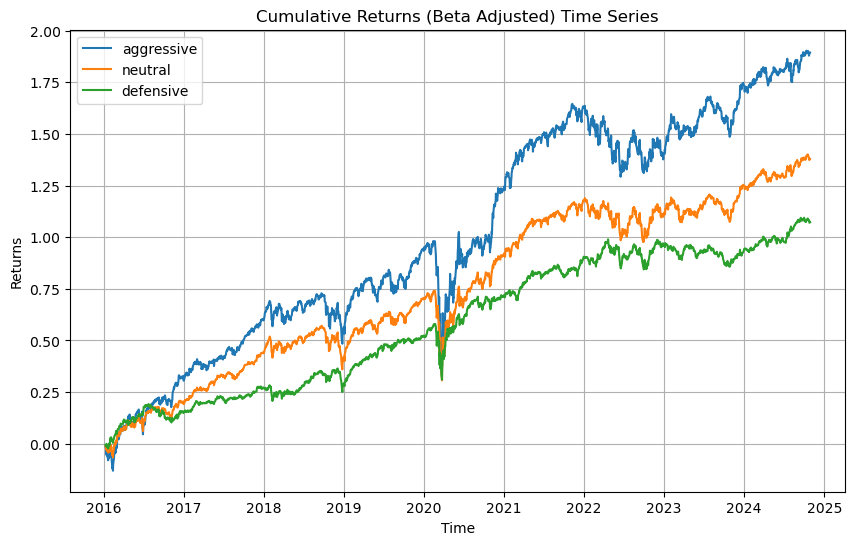

In [125]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(betas_portfolios_returns.cumsum(), label=betas_portfolios_returns.columns, alpha=1)

# Config
plt.title('Cumulative Returns (Beta Adjusted) Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

In [126]:
# Create the data
daily_rfr = (((1 + (rfr['risk_free_rate'].div(100)))**(1/360)) - 1)
benchmark_returns = sp500['sp_500'].pct_change(1)

# Create the Excess Returns
market_excess_returns = benchmark_returns - daily_rfr

In [127]:
# Create the regression dataframe
beta_regression_df = pd.DataFrame(index = betas_portfolios_returns.index)

beta_regression_df['aggressive_excess_returns'] = betas_portfolios_returns['aggressive'] - daily_rfr
beta_regression_df['defensive_excess_returns'] = betas_portfolios_returns['defensive'] - daily_rfr
beta_regression_df['market_excess_returns'] = market_excess_returns
beta_regression_df.dropna(inplace = True)

beta_regression_df

,aggressive_excess_returns,defensive_excess_returns,market_excess_returns
Date,,,
2016-01-08,-0.015013,-0.006266,-0.010897
2016-01-11,-0.007069,0.000681,0.000794
2016-01-12,0.004963,0.004061,0.007745
2016-01-13,-0.038574,-0.014276,-0.025023
2016-01-14,0.023733,0.009282,0.016638
...,...,...,...
2024-10-22,-0.006319,-0.001652,-0.000589
2024-10-23,-0.008404,0.001738,-0.009307
2024-10-24,0.005357,-0.002160,0.002031


In [128]:
# Create the Weights function
def wexp(N, half_life):
    c = np.log(0.5)/half_life
    n = np.array(range(N))
    w = np.exp(c*n)
    return np.flip(w/np.sum(w))

In [129]:
# Calculate the Beta for the Aggressive Portfolio

y = beta_regression_df['aggressive_excess_returns']

x = beta_regression_df['market_excess_returns']
x = sm.add_constant(x)

# Calculate Weights
window = len(y)
weights = window * wexp(window, window/2)

#Model specification
model = sm.WLS(
    y, 
    x,
    missing='drop',
    weights=weights,
    )   
     
#the results of the model
results = model.fit() 
    
#here we check the summary
print(results.summary())

                                WLS Regression Results                               
Dep. Variable:     aggressive_excess_returns   R-squared:                       0.847
Model:                                   WLS   Adj. R-squared:                  0.847
Method:                        Least Squares   F-statistic:                 1.219e+04
Date:                       Mon, 07 Apr 2025   Prob (F-statistic):               0.00
Time:                               19:30:44   Log-Likelihood:                 7774.1
No. Observations:                       2201   AIC:                        -1.554e+04
Df Residuals:                           2199   BIC:                        -1.553e+04
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

In [130]:
# Calculate the Beta for the Defensive Portfolio

y = beta_regression_df['defensive_excess_returns']

x = beta_regression_df['market_excess_returns']
x = sm.add_constant(x)

# Calculate Weights
window = len(y)
weights = window * wexp(window, window/2)

#Model specification
model = sm.WLS(
    y, 
    x,
    missing='drop',
    weights=weights,
    )   
     
#the results of the model
results = model.fit() 
    
#here we check the summary
print(results.summary())

                               WLS Regression Results                               
Dep. Variable:     defensive_excess_returns   R-squared:                       0.581
Model:                                  WLS   Adj. R-squared:                  0.580
Method:                       Least Squares   F-statistic:                     3043.
Date:                      Mon, 07 Apr 2025   Prob (F-statistic):               0.00
Time:                              19:30:44   Log-Likelihood:                 8301.4
No. Observations:                      2201   AIC:                        -1.660e+04
Df Residuals:                          2199   BIC:                        -1.659e+04
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

In [131]:
# Calculate the DMA Premium

beta_regression_df['AMD'] = betas_portfolios_returns['aggressive'] - betas_portfolios_returns['defensive']

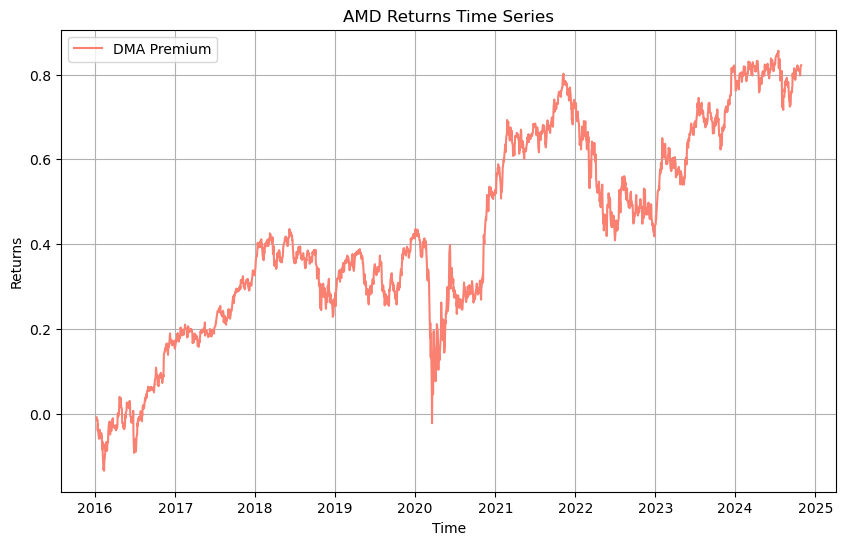

In [132]:
plt.figure(figsize=(10, 6))
plt.plot(beta_regression_df['AMD'].cumsum(), label='AMD Premium', color = 'salmon', alpha=1)

# Config
plt.title('AMD Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

In [133]:
# Check the Correlation with the Market

beta_regression_df['AMD'].corr(beta_regression_df['market_excess_returns'])

0.6954618744882957

In [134]:
# Calculate the Beta for the Defensive Portfolio

y = beta_regression_df['AMD']

x = beta_regression_df['market_excess_returns']
x = sm.add_constant(x)

# Calculate Weights
window = len(y)
weights = window * wexp(window, window/2)

#Model specification
model = sm.WLS(
    y, 
    x,
    missing='drop',
    weights=weights,
    )   
     
#the results of the model
results = model.fit() 
    
#here we check the summary
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:                    AMD   R-squared:                       0.491
Model:                            WLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     2121.
Date:                Mon, 07 Apr 2025   Prob (F-statistic):               0.00
Time:                        19:30:44   Log-Likelihood:                 6948.7
No. Observations:                2201   AIC:                        -1.389e+04
Df Residuals:                    2199   BIC:                        -1.388e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -5.206e-

In [135]:
# Store the Premium

beta_regression_df['AMD'].to_csv(r"..\additional_data\AMD.csv")